In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.seasonal import seasonal_decompose
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, GRU
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv('monthly_milk_production.csv')

In [4]:
df.head()

,Date,Production
0,1962-01,589
1,1962-02,561
2,1962-03,640
3,1962-04,656
4,1962-05,727


In [5]:
df.shape

(168, 2)

In [6]:
# Detect column names automatically
if len(df.columns) == 1:
    df = df.iloc[:, 0].str.split(',', expand=True)
df.columns = ['Month', 'Milk_Production']
df['Month'] = pd.to_datetime(df['Month'])
df['Milk_Production'] = pd.to_numeric(df['Milk_Production'], errors='coerce')
df.dropna(inplace=True)
df = df.sort_values('Month')
df.set_index('Month', inplace=True)

In [7]:
df.head()

,Milk_Production
Month,
1962-01-01,589
1962-02-01,561
1962-03-01,640
1962-04-01,656
1962-05-01,727


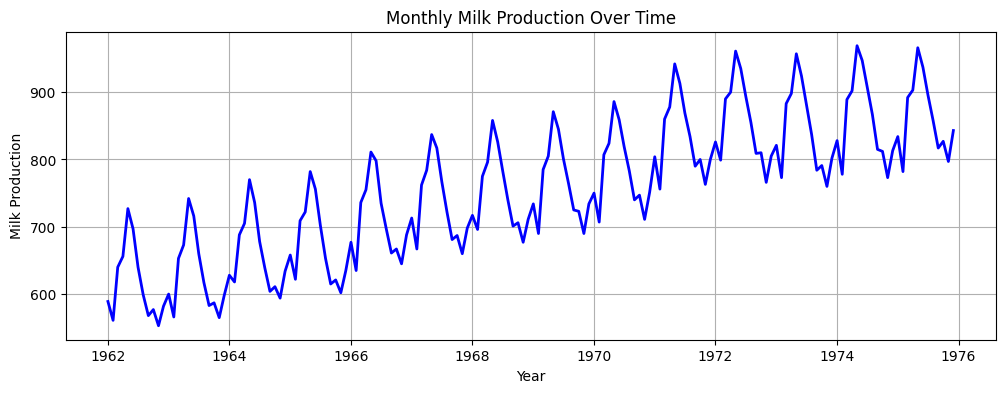

In [8]:
# Plot the time series
plt.figure(figsize=(12,4))
plt.plot(df.index, df['Milk_Production'], color='blue', linewidth=2)
plt.title("Monthly Milk Production Over Time")
plt.xlabel("Year")
plt.ylabel("Milk Production")
plt.grid(True)
plt.show()

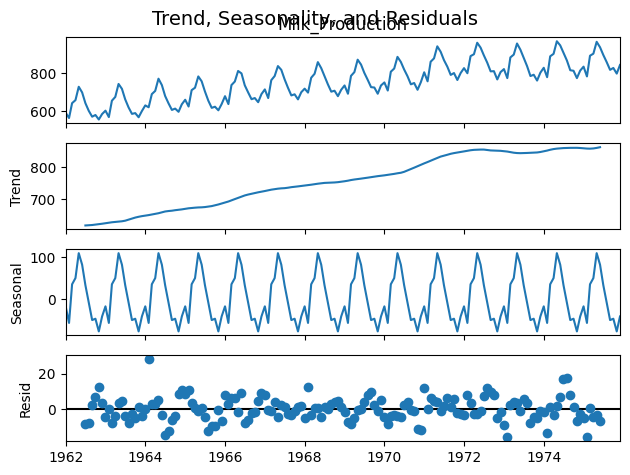

In [9]:
# Decomposition
decompose = seasonal_decompose(df['Milk_Production'], model='additive', period=12)
decompose.plot()
plt.suptitle("Trend, Seasonality, and Residuals", fontsize=14)
plt.show()

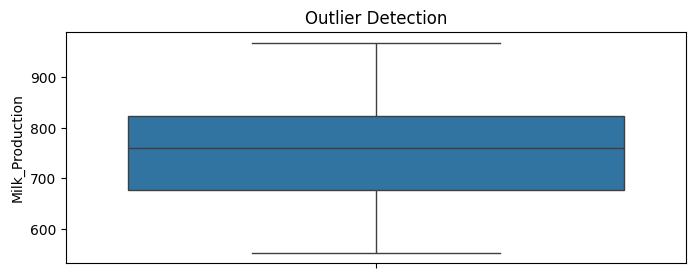

In [10]:
# Outlier check
plt.figure(figsize=(8,3))
sns.boxplot(df['Milk_Production'])
plt.title("Outlier Detection")
plt.show()

In [11]:
# Normalize
scaler = MinMaxScaler(feature_range=(0, 1))
df['Scaled'] = scaler.fit_transform(df[['Milk_Production']])


In [12]:
scaler

,"feature_range feature_range: tuple (min, max), default=(0, 1)Desired range of transformed data.","(0, ...)"
,"copy copy: bool, default=TrueSet to False to perform inplace row normalization and avoid acopy (if the input is already a numpy array).",True
,"clip clip: bool, default=FalseSet to True to clip transformed values of held-out data toprovided `feature_range`.Since this parameter will clip values, `inverse_transform` may notbe able to restore the original data... note:: Setting `clip=True` does not prevent feature drift (a distribution shift between training and test data). The transformed values are clipped to the `feature_range`, which helps avoid unintended behavior in models sensitive to out-of-range inputs (e.g. linear models). Use with care, as clipping can distort the distribution of test data... versionadded:: 0.24",False


In [13]:
# STEP 2: DATA PREPARATION

In [14]:
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

In [15]:
window_size = 12  # 12 months history to predict next month
data = df['Scaled'].values
X, y = create_sequences(data, window_size)

In [16]:
# Train / Validation / Test split
train_size = int(len(X) * 0.7)
val_size = int(len(X) * 0.15)

In [17]:
X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size + val_size], y[train_size:train_size + val_size]
X_test, y_test = X[train_size + val_size:], y[train_size + val_size:]

In [18]:
# Reshape for model [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [19]:
X_train.shape, X_val.shape, X_test.shape

((109, 12, 1), (23, 12, 1), (24, 12, 1))

In [20]:
# STEP 3: MODEL BUILDING - RNN, LSTM, GRU

In [21]:
def build_and_train(model_type, X_train, y_train, X_val, y_val, epochs=100, batch_size=8):
    model = Sequential()
    
    if model_type == "RNN":
        model.add(SimpleRNN(64, activation='tanh', input_shape=(X_train.shape[1], 1)))
    elif model_type == "LSTM":
        model.add(LSTM(64, activation='tanh', input_shape=(X_train.shape[1], 1)))
    elif model_type == "GRU":
        model.add(GRU(64, activation='tanh', input_shape=(X_train.shape[1], 1)))
    
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                        epochs=epochs, batch_size=batch_size, verbose=1,
                        callbacks=[early_stop])
    
    return model, history

In [22]:
models = {}
histories = {}

In [23]:
for model_type in ["RNN", "LSTM", "GRU"]:
    print(f"\nTraining {model_type} model...")
    model, history = build_and_train(model_type, X_train, y_train, X_val, y_val)
    models[model_type] = model
    histories[model_type] = history


Training RNN model...
Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1959 - val_loss: 0.0135
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0141 - val_loss: 0.0307
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0072 - val_loss: 0.0070
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0040 - val_loss: 0.0088
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0030 - val_loss: 0.0063
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0030 - val_loss: 0.0052
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0029 - val_loss: 0.0068
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0025 - val_loss: 0.0050
Epoch 9/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0024 - val_loss: 0.0052
Epoch 10/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0023 - val_loss: 0.0046
Epoch 11/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0023 - val_loss: 0.0044
Epoch 12/100
14/14 ━━━━━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step

RNN Model Performance:
RMSE: 14.317
MAE:  11.861
MAPE: 1.36%


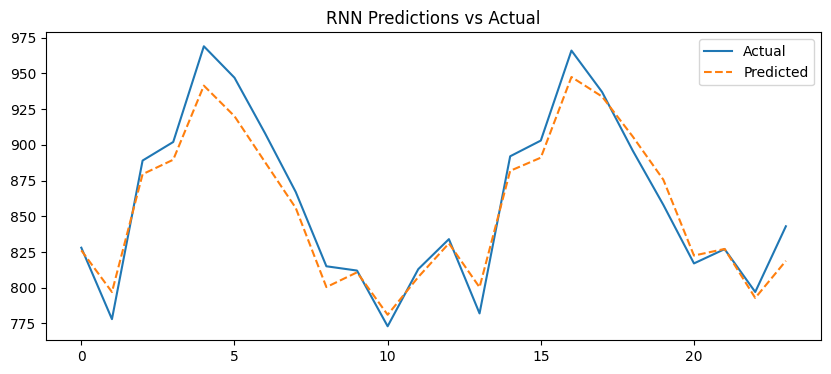

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step

LSTM Model Performance:
RMSE: 27.746
MAE:  23.254
MAPE: 2.70%


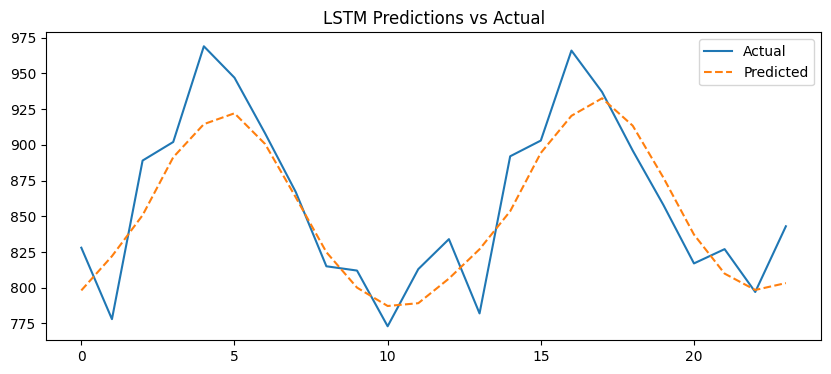

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step

GRU Model Performance:
RMSE: 32.745
MAE:  25.003
MAPE: 2.96%


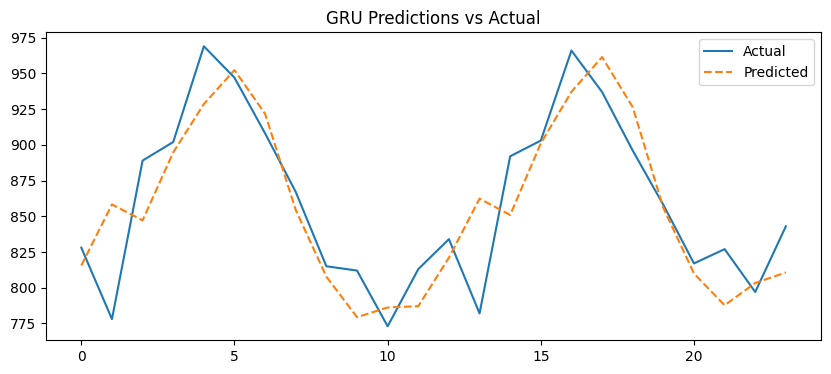

In [24]:
# STEP 4: EVALUATION
def evaluate_model(model, X_test, y_test, name):
    y_pred = model.predict(X_test)
    y_pred_inv = scaler.inverse_transform(y_pred)
    y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
    
    rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
    mae = mean_absolute_error(y_test_inv, y_pred_inv)
    mape = np.mean(np.abs((y_test_inv - y_pred_inv) / y_test_inv)) * 100
    
    print(f"\n{name} Model Performance:")
    print(f"RMSE: {rmse:.3f}")
    print(f"MAE:  {mae:.3f}")
    print(f"MAPE: {mape:.2f}%")
    
    plt.figure(figsize=(10,4))
    plt.plot(y_test_inv, label="Actual")
    plt.plot(y_pred_inv, label="Predicted", linestyle='--')
    plt.title(f"{name} Predictions vs Actual")
    plt.legend()
    plt.show()
    
    return rmse, mae, mape

results = {}
for name, model in models.items():
    results[name] = evaluate_model(model, X_test, y_test, name)

In [25]:
# STEP 5: FUTURE FORECAST (NEXT 12 MONTHS)

In [26]:
best_model_name = min(results, key=lambda x: results[x][0])  # model with lowest RMSE
best_model = models[best_model_name]

In [27]:
best_model_name

'RNN'

In [28]:
last_sequence = data[-window_size:]
predictions = []

In [29]:
for i in range(12):  # forecast next 12 months
    seq = last_sequence[-window_size:].reshape((1, window_size, 1))
    next_pred = best_model.predict(seq)
    predictions.append(next_pred[0,0])
    last_sequence = np.append(last_sequence, next_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


In [30]:
# Inverse scale
predictions_inv = scaler.inverse_transform(np.array(predictions).reshape(-1,1))

In [31]:
# Create forecast dataframe
future_dates = pd.date_range(df.index[-1] + pd.offsets.MonthBegin(1), periods=12, freq='MS')
forecast_df = pd.DataFrame({'Month': future_dates, 'Forecasted_Milk_Production': predictions_inv.flatten()})

In [32]:
forecast_df

,Month,Forecasted_Milk_Production
0,1976-01-01,839.077454
1,1976-02-01,805.912415
2,1976-03-01,885.982849
3,1976-04-01,893.468933
4,1976-05-01,944.406006
5,1976-06-01,924.445374
6,1976-07-01,897.801697
7,1976-08-01,869.768433
8,1976-09-01,829.462463
9,1976-10-01,841.920898


In [33]:
future_dates

DatetimeIndex(['1976-01-01', '1976-02-01', '1976-03-01', '1976-04-01',
               '1976-05-01', '1976-06-01', '1976-07-01', '1976-08-01',
               '1976-09-01', '1976-10-01', '1976-11-01', '1976-12-01'],
              dtype='datetime64[ns]', freq='MS')

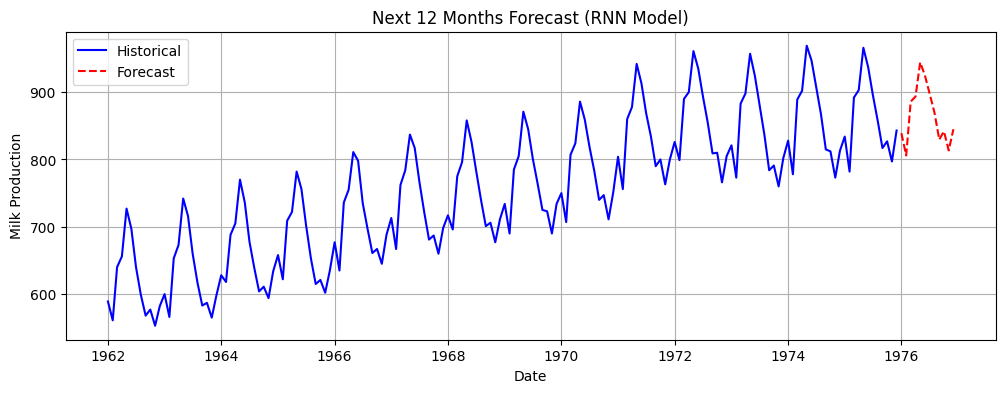

In [34]:
# Plot forecast
plt.figure(figsize=(12,4))
plt.plot(df.index, df['Milk_Production'], label='Historical', color='blue')
plt.plot(forecast_df['Month'], forecast_df['Forecasted_Milk_Production'], label='Forecast', color='red', linestyle='--')
plt.title(f"Next 12 Months Forecast ({best_model_name} Model)")
plt.xlabel("Date")
plt.ylabel("Milk Production")
plt.legend()
plt.grid(True)
plt.show()

In [35]:
# STEP 6: BUSINESS INSIGHTS

In [36]:
print(f"""
 Business Insights:
1. The {best_model_name} model achieved the lowest RMSE, indicating the best forecasting accuracy.
2. Forecasts help anticipate seasonal dips and peaks — aiding supply chain and storage management.
3. Accurate forecasts enable better workforce planning and inventory allocation.
4. Using 12 months of history per prediction captures annual seasonality effectively.
5. Continuous retraining with new data can improve accuracy further.
""")


 Business Insights:
1. The RNN model achieved the lowest RMSE, indicating the best forecasting accuracy.
2. Forecasts help anticipate seasonal dips and peaks — aiding supply chain and storage management.
3. Accurate forecasts enable better workforce planning and inventory allocation.
4. Using 12 months of history per prediction captures annual seasonality effectively.
5. Continuous retraining with new data can improve accuracy further.

